### DeepFM :https://github.com/shenweichen/DeepCTR-Torch
### Paper : https://www.ijcai.org/proceedings/2017/0239.pdf
 * DeepFM do not need domain knowledge because this model Don't use feature engineering
 * So We run it!

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import gc

plt.style.use('ggplot')

import warnings as w
w.filterwarnings(action='ignore')
pd.set_option('display.max_columns',None)

In [2]:
dtype={'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.str,
    'C1': np.dtype(str),
    'banner_pos': np.dtype(str),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C14': np.dtype(str),
    'C15': np.dtype(str),
    'C16': np.dtype(str),
    'C17': np.dtype(str),
    'C18': np.dtype(str),
    'C19': np.dtype(str),
    'C20': np.dtype(str),
    'C21':np.dtype(str)
      }
num_records = 40428967
sample_size = 500000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

In [4]:
train = pd.read_csv("avazu-ctr-prediction/train.gz", parse_dates=['hour'], date_parser=parse_date, dtype=dtype, skiprows=skip_values)
test = pd.read_csv("avazu-ctr-prediction/test.gz", parse_dates=['hour'], date_parser=parse_date, dtype=dtype)
submission = pd.read_csv('avazu-ctr-prediction/sampleSubmission.gz')
print('Train dataset:',train.shape)
print('Test dataset:',test.shape)
print('Submission:',submission.shape)

Train dataset: (500000, 24)
Test dataset: (4577464, 23)
Submission: (4577464, 2)


### Feature Expalin
  1. id : personal_id
  2. click : target
  3. hour : datetime
  4. C1 : anonymized categorical variable
  5. banner_pos : showing banner
  6. site domain
  7. site_category 
  8. app_id 
  9. add_category
  10. device_id 
  11. device_ip
  12. device_model
  13. device_type
  14. device_conn_type
  15. C14 ~ C21 : anonymized categorical variables

In [5]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1001795364355496701,0,2014-10-21,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,3033c66f,eba9519f,1,0,19771,320,50,2227,0,687,100081,48
1,10019540781113332955,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,0489ce3f,8a4875bd,1,0,15702,320,50,1722,0,35,-1,79
2,10039942169341766270,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e54c1344,1f0bc64f,1,0,15707,320,50,1722,0,35,-1,79
3,10058801181525912053,0,2014-10-21,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,13453fb5,a0f5f879,1,0,19950,320,50,1800,3,167,100077,23
4,10084015716773008131,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,5e3f096f,2347f47a,0f2161f8,a99f214a,d5f8b9cd,2cd8ff6d,1,0,18993,320,50,2161,0,35,-1,157


In [6]:
test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,2014-10-31,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51
2,1.000055e+19,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,10fb085b,1f0bc64f,1,0,22676,320,50,2616,0,35,100083,51
3,1.000109e+19,2014-10-31,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,422d257a,542422a7,1,0,18648,320,50,1092,3,809,100156,61
4,1.000138e+19,2014-10-31,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,078c6b38,1f0bc64f,1,0,23160,320,50,2667,0,47,-1,221


In [7]:
train.isna().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

0    415736
1     84264
Name: click, dtype: int64


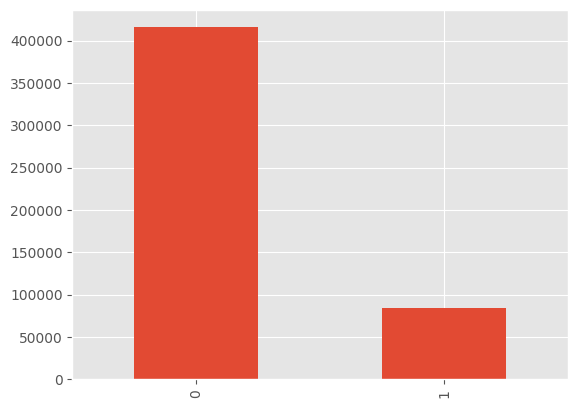

In [8]:
train.click.value_counts().plot(kind='bar')
print(train.click.value_counts())

## Target feature data imbalance

In [9]:
train.banner_pos.value_counts()

0    360305
1    138765
7       564
2       164
4        95
5        79
3        28
Name: banner_pos, dtype: int64

<AxesSubplot: xlabel='banner_pos', ylabel='count'>

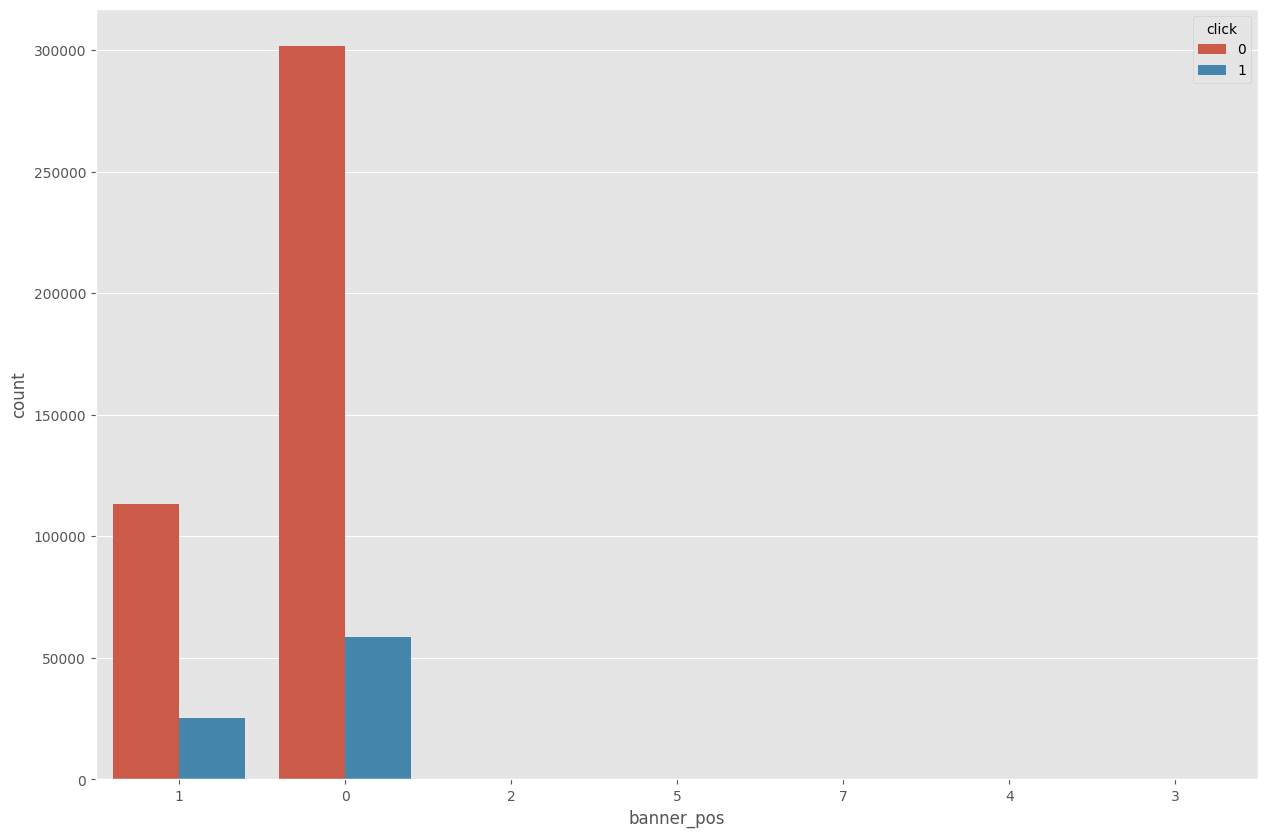

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(x='banner_pos',hue='click',data=train)

### Banner pos is not effienct increasing user click  

<AxesSubplot: xlabel='hour', ylabel='count'>

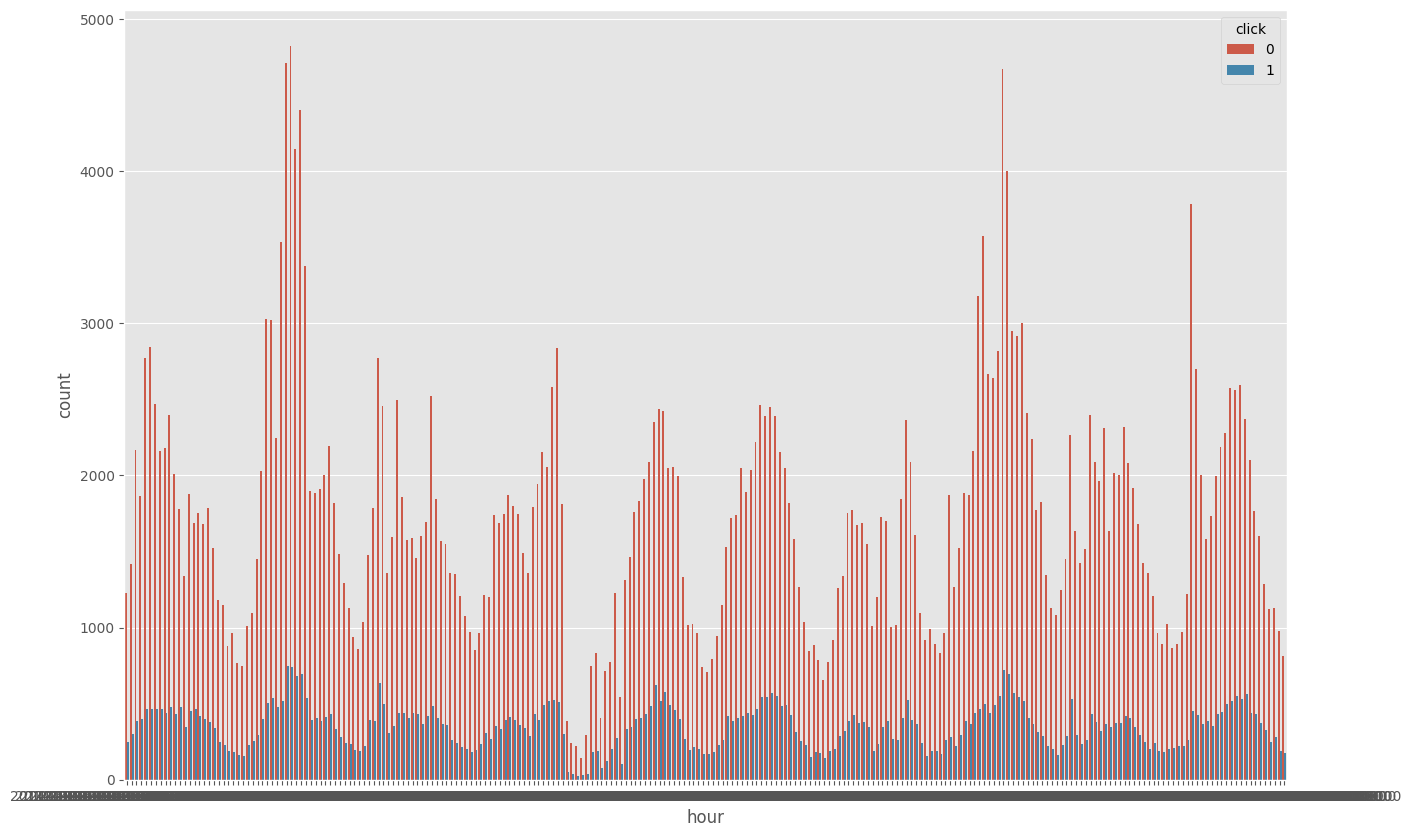

In [11]:
plt.figure(figsize=(15,10))
sns.countplot(x='hour',hue='click',data=train)

### The date is too long to identify characteristics, so sample data is taken to run a sample survey

In [12]:
ex_data = train[train.hour < '2014-10-22']
ex_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1001795364355496701,0,2014-10-21,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,3033c66f,eba9519f,1,0,19771,320,50,2227,0,687,100081,48
1,10019540781113332955,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,0489ce3f,8a4875bd,1,0,15702,320,50,1722,0,35,-1,79
2,10039942169341766270,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e54c1344,1f0bc64f,1,0,15707,320,50,1722,0,35,-1,79
3,10058801181525912053,0,2014-10-21,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,13453fb5,a0f5f879,1,0,19950,320,50,1800,3,167,100077,23
4,10084015716773008131,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,5e3f096f,2347f47a,0f2161f8,a99f214a,d5f8b9cd,2cd8ff6d,1,0,18993,320,50,2161,0,35,-1,157


<AxesSubplot: xlabel='hour', ylabel='count'>

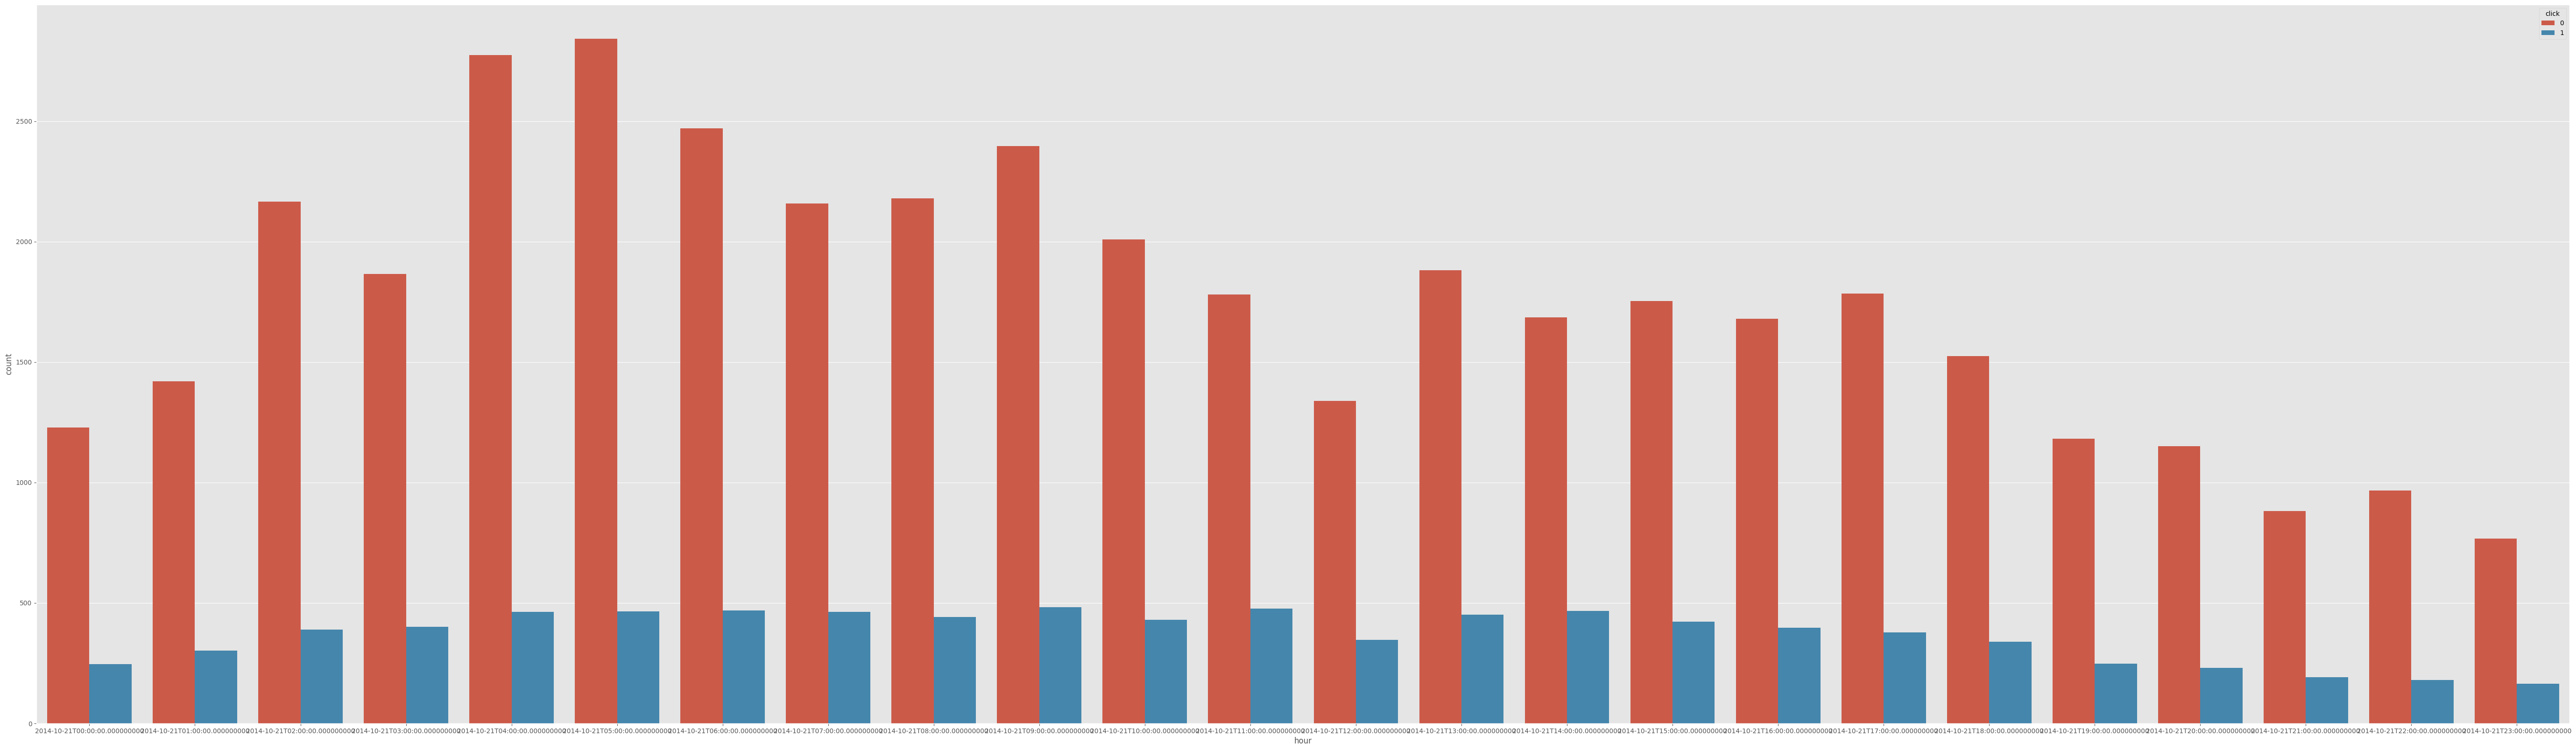

In [13]:
plt.figure(figsize=(70,20))
sns.countplot(x='hour',hue='click',data=ex_data)

### Clicks don't seem to be affected by time

In [14]:
del ex_data
gc.collect()

3853

In [15]:
train.set_index('hour',inplace=True)

In [16]:
test.set_index('hour',inplace=True)

In [17]:
train.head()

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,,,
2014-10-21,1001795364355496701,0,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,3033c66f,eba9519f,1,0,19771,320,50,2227,0,687,100081,48
2014-10-21,10019540781113332955,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,0489ce3f,8a4875bd,1,0,15702,320,50,1722,0,35,-1,79
2014-10-21,10039942169341766270,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e54c1344,1f0bc64f,1,0,15707,320,50,1722,0,35,-1,79
2014-10-21,10058801181525912053,0,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,13453fb5,a0f5f879,1,0,19950,320,50,1800,3,167,100077,23
2014-10-21,10084015716773008131,0,1005,0,85f751fd,c4e18dd6,50e219e0,5e3f096f,2347f47a,0f2161f8,a99f214a,d5f8b9cd,2cd8ff6d,1,0,18993,320,50,2161,0,35,-1,157


### sparse feature
 * C1
 * banner_pos
 * site_id
 * site_domain
 * site_category
 * app_id
 * app_domain
 * app_category
 * device_id
 * device_ip
 * device_model
 * device_type
 * device_conn_type

### Dense feature
 * C14 ~ c21

In [18]:
!pip install deepctr_torch


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.8 -m pip install --upgrade pip


In [19]:
import torch
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *

In [20]:
train

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,,,
2014-10-21 00:00:00,1001795364355496701,0,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,3033c66f,eba9519f,1,0,19771,320,50,2227,0,687,100081,48
2014-10-21 00:00:00,10019540781113332955,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,0489ce3f,8a4875bd,1,0,15702,320,50,1722,0,35,-1,79
2014-10-21 00:00:00,10039942169341766270,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e54c1344,1f0bc64f,1,0,15707,320,50,1722,0,35,-1,79
2014-10-21 00:00:00,10058801181525912053,0,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,13453fb5,a0f5f879,1,0,19950,320,50,1800,3,167,100077,23
2014-10-21 00:00:00,10084015716773008131,0,1005,0,85f751fd,c4e18dd6,50e219e0,5e3f096f,2347f47a,0f2161f8,a99f214a,d5f8b9cd,2cd8ff6d,1,0,18993,320,50,2161,0,35,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-30 23:00:00,9949735612971063251,0,1005,0,f58d0bc8,7e3be6ba,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,a4efe2e4,be74e6fe,1,0,17239,320,50,1973,3,39,100148,23
2014-10-30 23:00:00,995541124371666135,0,1005,0,85f751fd,c4e18dd6,50e219e0,90be40ff,d9b5648e,0f2161f8,a99f214a,ac72553b,f4fffcd0,1,0,23866,320,50,2736,0,33,100170,246
2014-10-30 23:00:00,9961234758570278189,0,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,a99f214a,1f566a01,99e427c9,1,0,21611,320,50,2480,3,299,100111,61


In [52]:
train.iloc[::,2:14]

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type
hour,,,,,,,,,,,,
2014-10-21 00:00:00,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,07d7df22,a99f214a,5035aded,3db9fde9,1
2014-10-21 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ef8cc324,5096d134,1
2014-10-21 00:00:00,1005,1,43d6df75,27e3c518,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,07d906d8,ac221d6c,1
2014-10-21 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,8a014cbb,04f5b394,1
2014-10-21 00:00:00,1005,0,6ec06dbd,d262cf1e,f66779e6,ecad2386,7801e8d9,07d7df22,a99f214a,03b897c3,7120e05e,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-30 23:00:00,1010,1,85f751fd,c4e18dd6,50e219e0,ffc6ffd0,7801e8d9,0f2161f8,f3dfd822,7658e752,f07e20f8,4
2014-10-30 23:00:00,1005,0,c36224b6,5218cef0,335d28a8,ecad2386,7801e8d9,07d7df22,a99f214a,e5081591,d787e91b,1
2014-10-30 23:00:00,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,168dd899,4d392e74,1


In [84]:
train

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,,,
2014-10-21 00:00:00,2753685,0,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,07d7df22,a99f214a,5035aded,3db9fde9,1,0,18993,320,50,2161,0,35,-1,157
2014-10-21 00:00:00,2763458,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ef8cc324,5096d134,1,0,15702,320,50,1722,0,35,-1,79
2014-10-21 00:00:00,2763912,0,1005,1,43d6df75,27e3c518,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,07d906d8,ac221d6c,1,0,9461,320,50,901,3,1315,-1,61
2014-10-21 00:00:00,2768439,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,8a014cbb,04f5b394,1,0,15702,320,50,1722,0,35,-1,79
2014-10-21 00:00:00,2770851,0,1005,0,6ec06dbd,d262cf1e,f66779e6,ecad2386,7801e8d9,07d7df22,a99f214a,03b897c3,7120e05e,1,0,17163,320,50,1955,3,163,100189,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-30 23:00:00,2735672,1,1010,1,85f751fd,c4e18dd6,50e219e0,ffc6ffd0,7801e8d9,0f2161f8,f3dfd822,7658e752,f07e20f8,4,0,22866,320,50,2644,3,35,-1,23
2014-10-30 23:00:00,2744873,0,1005,0,c36224b6,5218cef0,335d28a8,ecad2386,7801e8d9,07d7df22,a99f214a,e5081591,d787e91b,1,0,22614,300,250,2610,3,167,100199,23
2014-10-30 23:00:00,2749696,0,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,168dd899,4d392e74,1,0,19771,320,50,2227,0,935,-1,48


In [34]:
sparse_features = train.iloc[::,2:15].columns.values.tolist()
dense_features = train.iloc[::,15:].columns.values.tolist()
sparse_features.append('id')
target = ['click']

In [35]:
print(test.columns, len(test.columns))

Index(['id', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object') 22


In [36]:
print(train.columns, len(train.columns))

Index(['id', 'click', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object') 23


In [37]:
train

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,,,
2014-10-21 00:00:00,1001795364355496701,0,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,3033c66f,eba9519f,1,0,19771,320,50,2227,0,687,100081,48
2014-10-21 00:00:00,10019540781113332955,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,0489ce3f,8a4875bd,1,0,15702,320,50,1722,0,35,-1,79
2014-10-21 00:00:00,10039942169341766270,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e54c1344,1f0bc64f,1,0,15707,320,50,1722,0,35,-1,79
2014-10-21 00:00:00,10058801181525912053,0,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,13453fb5,a0f5f879,1,0,19950,320,50,1800,3,167,100077,23
2014-10-21 00:00:00,10084015716773008131,0,1005,0,85f751fd,c4e18dd6,50e219e0,5e3f096f,2347f47a,0f2161f8,a99f214a,d5f8b9cd,2cd8ff6d,1,0,18993,320,50,2161,0,35,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-30 23:00:00,9949735612971063251,0,1005,0,f58d0bc8,7e3be6ba,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,a4efe2e4,be74e6fe,1,0,17239,320,50,1973,3,39,100148,23
2014-10-30 23:00:00,995541124371666135,0,1005,0,85f751fd,c4e18dd6,50e219e0,90be40ff,d9b5648e,0f2161f8,a99f214a,ac72553b,f4fffcd0,1,0,23866,320,50,2736,0,33,100170,246
2014-10-30 23:00:00,9961234758570278189,0,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,a99f214a,1f566a01,99e427c9,1,0,21611,320,50,2480,3,299,100111,61


In [38]:
test.head()

,id,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,,
2014-10-31,1.000017e+19,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
2014-10-31,1.000018e+19,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51
2014-10-31,1.000055e+19,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,10fb085b,1f0bc64f,1,0,22676,320,50,2616,0,35,100083,51
2014-10-31,1.000109e+19,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,422d257a,542422a7,1,0,18648,320,50,1092,3,809,100156,61
2014-10-31,1.000138e+19,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,078c6b38,1f0bc64f,1,0,23160,320,50,2667,0,47,-1,221


In [39]:
for idx, column in enumerate(train.columns):
    print(f'{idx}\t{column:30} \t {len(train[column].unique())}')

0	id                             	 500000
1	click                          	 2
2	C1                             	 7
3	banner_pos                     	 7
4	site_id                        	 2253
5	site_domain                    	 2332
6	site_category                  	 21
7	app_id                         	 2433
8	app_domain                     	 161
9	app_category                   	 27
10	device_id                      	 79402
11	device_ip                      	 313796
12	device_model                   	 4608
13	device_type                    	 5
14	device_conn_type               	 4
15	C14                            	 2125
16	C15                            	 8
17	C16                            	 9
18	C17                            	 420
19	C18                            	 4
20	C19                            	 65
21	C20                            	 162
22	C21                            	 60


In [40]:
len(train.C1.unique())

7

In [41]:
test_sparse_features = test.iloc[::,0:14].columns.values.tolist()
test_dense_features = test.iloc[::,14:].columns.values.tolist()

In [42]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
scaler = MinMaxScaler(feature_range=(0,1))
encoder = LabelEncoder()

In [43]:
test_encoder = LabelEncoder()

In [44]:
test_encoder.fit([['1'], ['2'], ['3']])

LabelEncoder()

In [45]:
test_encoder.transform([['1'], ['2'], ['3']])

array([0, 1, 2])

In [46]:
train[dense_features].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500000 entries, 2014-10-21 00:00:00 to 2014-10-30 23:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   C14     500000 non-null  object
 1   C15     500000 non-null  object
 2   C16     500000 non-null  object
 3   C17     500000 non-null  object
 4   C18     500000 non-null  object
 5   C19     500000 non-null  object
 6   C20     500000 non-null  object
 7   C21     500000 non-null  object
dtypes: object(8)
memory usage: 34.3+ MB


In [47]:
for feat in test_sparse_features:
    print(feat)
    encoder.fit(pd.concat([train[feat], test[feat]]))
    train[feat] = encoder.transform(train[feat])
    test[feat] = encoder.transform(test[feat])
scaler.fit(pd.concat([train[dense_features], test[dense_features]]))
train[dense_features] = scaler.transform(train[dense_features])
test[dense_features] = scaler.transform(test[test_dense_features])

id
C1
banner_pos
site_id
site_domain
site_category
app_id
app_domain
app_category
device_id
device_ip
device_model
device_type
device_conn_type


In [120]:
train

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,,,
2014-10-21 00:00:00,275854,0,2,1,2258,2609,21,4253,118,0,241463,245978,5327,1,0,0.809043,0.221239,0.02988,0.788885,0.0,0.362126,0.998334,0.185039
2014-10-21 00:00:00,2757319,0,2,0,393,3562,2,4253,118,0,241463,23089,3120,1,0,0.639318,0.221239,0.02988,0.600522,0.0,0.001107,0.000000,0.307087
2014-10-21 00:00:00,2763035,0,2,0,393,3562,2,4253,118,0,241463,1172613,683,1,0,0.639526,0.221239,0.02988,0.600522,0.0,0.001107,0.000000,0.307087
2014-10-21 00:00:00,2768343,0,2,1,1654,1295,21,4253,118,0,241463,98163,3634,1,0,0.816510,0.221239,0.02988,0.629616,1.0,0.074197,0.998294,0.086614
2014-10-21 00:00:00,2775192,0,2,0,1660,2879,6,1693,30,4,241463,1094336,980,1,0,0.776591,0.221239,0.02988,0.764267,0.0,0.001107,0.000000,0.614173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-30 23:00:00,2738096,0,2,0,3004,1859,21,4253,118,0,241463,843188,4252,1,0,0.703429,0.221239,0.02988,0.694144,1.0,0.003322,0.999002,0.086614
2014-10-30 23:00:00,274146,0,2,0,1660,2879,6,2597,219,4,241463,881382,5540,1,0,0.979853,0.221239,0.02988,0.978739,0.0,0.000000,0.999222,0.964567
2014-10-30 23:00:00,2741307,0,2,0,1660,2879,6,4592,131,4,241463,159811,3461,1,0,0.885793,0.221239,0.02988,0.883253,1.0,0.147287,0.998633,0.236220


In [48]:
train_test = pd.concat([train, test])

In [49]:
fixlen_feature_columns = [SparseFeat(feat, train_test[feat].nunique(), use_hash=train_test[feat].nunique()>1000000) for feat in sparse_features]
fixlen_feature_columns += [DenseFeat(feat,1,) for feat in dense_features]

Notice! Feature Hashing on the fly currently is not supported in torch version,you can use tensorflow version!
Notice! Feature Hashing on the fly currently is not supported in torch version,you can use tensorflow version!


In [50]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

In [51]:
dnn_feature_columns

[SparseFeat(name='C1', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='C1', group_name='default_group'),
 SparseFeat(name='banner_pos', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='banner_pos', group_name='default_group'),
 SparseFeat(name='site_id', vocabulary_size=3143, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='site_id', group_name='default_group'),
 SparseFeat(name='site_domain', vocabulary_size=3754, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='site_domain', group_name='default_group'),
 SparseFeat(name='site_category', vocabulary_size=23, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='site_category', group_name='default_group'),
 SparseFeat(name='app_id', vocabulary_size=4613, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='app_id', group_name='default_group'),
 SparseFeat(name='app_domain', vocabulary_size=258, embedding_dim=4, use_has

In [52]:
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
feature_names

['C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'device_type',
 'device_conn_type',
 'id',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

In [53]:
train_model_input = {name: train[name].values for name in feature_names}

In [54]:
train_model_input

{'C1': array([2, 2, 2, ..., 2, 2, 2]),
 'banner_pos': array([1, 0, 0, ..., 0, 0, 0]),
 'site_id': array([2258,  393,  393, ..., 1660, 1660,  393]),
 'site_domain': array([2609, 3562, 3562, ..., 2879, 2879, 3562]),
 'site_category': array([21,  2,  2, ...,  6,  6,  2]),
 'app_id': array([4253, 4253, 4253, ..., 4592, 3775, 4253]),
 'app_domain': array([118, 118, 118, ..., 131,   6, 118]),
 'app_category': array([0, 0, 0, ..., 4, 4, 0]),
 'device_id': array([241463, 241463, 241463, ..., 241463, 241463, 241463]),
 'device_ip': array([ 245978,   23089, 1172613, ...,  159811,  782651,  281620]),
 'device_model': array([5327, 3120,  683, ..., 3461, 1561, 2542]),
 'device_type': array([1, 1, 1, ..., 1, 1, 1]),
 'device_conn_type': array([0, 0, 0, ..., 0, 1, 0]),
 'id': array([ 275854, 2757319, 2763035, ..., 2741307, 2745805, 2751882]),
 'C14': array([0.80904313, 0.63931759, 0.63952615, ..., 0.88579294, 0.97985317,
        0.9127388 ]),
 'C15': array([0.22123894, 0.22123894, 0.22123894, ..., 0.

In [55]:
test_model_input = {name: test[name].values for name in feature_names}

In [56]:
test_model_input

{'C1': array([2, 2, 2, ..., 2, 2, 2]),
 'banner_pos': array([0, 0, 0, ..., 0, 0, 0]),
 'site_id': array([ 435,  393,  393, ..., 1179, 1660,  297]),
 'site_domain': array([3609, 3562, 3562, ..., 1752, 2879, 3562]),
 'site_category': array([21,  2,  2, ...,  4,  6, 21]),
 'app_id': array([4253, 4253, 4253, ..., 4253, 2638, 4253]),
 'app_domain': array([118, 118, 118, ..., 118, 174, 118]),
 'app_category': array([0, 0, 0, ..., 0, 4, 0]),
 'device_id': array([241463, 241463, 241463, ..., 241463, 241463, 241463]),
 'device_ip': array([ 541649, 1190718,   86470, ...,  981530,  526278,   94112]),
 'device_model': array([ 341, 5352,  683, ..., 4710,  118, 3634]),
 'device_type': array([1, 1, 1, ..., 1, 1, 1]),
 'device_conn_type': array([0, 0, 0, ..., 0, 2, 0]),
 'id': array([2751992, 2751994, 2752081, ...,   27542, 2751696,   27543]),
 'C14': array([0.3318178 , 0.93021607, 0.93021607, ..., 0.72073913, 0.97947777,
        0.91261366]),
 'C15': array([0.22123894, 0.22123894, 0.22123894, ..., 0.

In [58]:
from deepctr_torch.models import PLE

In [59]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [110]:
# device = 'mps'

In [111]:
help(PLE)

Help on class PLE in module deepctr_torch.models.multitask.ple:

class PLE(deepctr_torch.models.basemodel.BaseModel)
 |  PLE(dnn_feature_columns, shared_expert_num=1, specific_expert_num=1, num_levels=2, expert_dnn_hidden_units=(256, 128), gate_dnn_hidden_units=(64,), tower_dnn_hidden_units=(64,), l2_reg_linear=1e-05, l2_reg_embedding=1e-05, l2_reg_dnn=0, init_std=0.0001, seed=1024, dnn_dropout=0, dnn_activation='relu', dnn_use_bn=False, task_types=('binary', 'binary'), task_names=('ctr', 'ctcvr'), device='cpu', gpus=None)
 |  
 |  Instantiates the multi level of Customized Gate Control of Progressive Layered Extraction architecture.
 |  
 |  :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
 |  :param shared_expert_num: integer, number of task-shared experts.
 |  :param specific_expert_num: integer, number of task-specific experts.
 |  :param num_levels: integer, number of CGC levels.
 |  :param expert_dnn_hidden_units: list, list of p

In [112]:
model = PLE(dnn_feature_columns,device=device,dnn_dropout=0.7, task_types=['binary', 'regression'])
model

PLE(
  (embedding_dict): ModuleDict(
    (C1): Embedding(7, 4)
    (banner_pos): Embedding(7, 4)
    (site_id): Embedding(3143, 4)
    (site_domain): Embedding(3754, 4)
    (site_category): Embedding(23, 4)
    (app_id): Embedding(4613, 4)
    (app_domain): Embedding(258, 4)
    (app_category): Embedding(30, 4)
    (device_id): Embedding(364622, 4)
    (device_ip): Embedding(1309462, 4)
    (device_model): Embedding(5788, 4)
    (device_type): Embedding(5, 4)
    (device_conn_type): Embedding(4, 4)
    (id): Embedding(5077464, 4)
  )
  (linear_model): Linear(
    (embedding_dict): ModuleDict()
  )
  (out): ModuleList(
    (0-1): 2 x PredictionLayer()
  )
  (specific_experts): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ModuleList(
        (0): DNN(
          (dropout): Dropout(p=0.7, inplace=False)
          (linears): ModuleList(
            (0): Linear(in_features=64, out_features=256, bias=True)
            (1): Linear(in_features=256, out_features=128, bias=True)
          )


In [113]:
from torch.optim import AdamW

In [114]:
optim = AdamW(params=model.parameters())

In [115]:
model.compile(optimizer = optim,
              loss = 'binary_crossentropy',
              metrics = ['binary_crossentropy','auc'])

In [116]:
train[target].values

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [117]:
from torch.nn.functional import one_hot

In [118]:
y = one_hot(torch.tensor(train[target].values)).numpy().squeeze(1)

In [119]:
%%time
history = model.fit(train_model_input, y, batch_size=1024, epochs=5, verbose=1,
                        validation_split=0.2)

mps
Train on 400000 samples, validate on 100000 samples, 391 steps per epoch


0it [00:00, ?it/s]


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [199]:
pred_ans = model.predict(test_model_input, 1024)

In [200]:
submission['click'] = pred_ans

In [201]:
submission

,id,click
0,10000174058809263569,0.185040
1,10000182526920855428,0.193212
2,10000554139829213984,0.180132
3,10001094637809798845,0.060254
4,10001377041558670745,0.262114
...,...,...
4577459,9998166651591969718,0.413355
4577460,9998249812366450951,0.223385
4577461,99988023653614546,0.378668
4577462,9999086574712596585,0.017322


In [227]:
submission

,id,click
0,10000174058809263569,0.185040
1,10000182526920855428,0.193212
2,10000554139829213984,0.180132
3,10001094637809798845,0.060254
4,10001377041558670745,0.262114
...,...,...
4577459,9998166651591969718,0.413355
4577460,9998249812366450951,0.223385
4577461,99988023653614546,0.378668
4577462,9999086574712596585,0.017322


In [202]:
submission.to_csv('submission.csv',index=False)

In [224]:
test

,id,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
hour,,,,,,,,,,,,,,,,,,,,,,
2014-10-31 00:00:00,2751808,2,0,423,3571,20,4270,115,0,241348,541642,338,1,0,0.331818,0.221239,0.029880,0.242074,1.000000,0.078627,0.998274,0.086614
2014-10-31 00:00:00,2751810,2,0,379,3522,1,4270,115,0,241348,1190549,5345,1,0,0.930216,0.221239,0.029880,0.933980,0.000000,0.001107,0.998354,0.196850
2014-10-31 00:00:00,2751893,2,0,379,3522,1,4270,115,0,241348,86578,670,1,0,0.930216,0.221239,0.029880,0.933980,0.000000,0.001107,0.998354,0.196850
2014-10-31 00:00:00,2752055,2,0,1647,2852,5,1447,169,4,241348,337850,1881,1,0,0.762201,0.221239,0.029880,0.365535,1.000000,0.429679,0.999082,0.236220
2014-10-31 00:00:00,2752114,2,0,1647,2852,5,2808,32,27,241348,38517,670,1,0,0.950405,0.221239,0.029880,0.953003,0.000000,0.007752,0.000000,0.866142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-31 23:00:00,2751262,2,0,1818,1729,3,4270,115,0,241348,965494,3004,1,0,0.720739,0.199115,0.229084,0.701977,0.666667,0.003322,0.000000,0.125984
2014-10-31 23:00:00,2751286,2,0,285,3522,20,4270,115,0,241348,162966,4862,1,0,0.906357,0.221239,0.029880,0.907497,0.000000,0.220377,0.998364,0.866142
2014-10-31 23:00:00,27442,2,0,1169,1729,3,4270,115,0,241348,981700,4711,1,0,0.720739,0.199115,0.229084,0.701977,0.666667,0.003322,0.000000,0.125984


In [208]:
for column in train.columns:
    print(column, '\t', train[column].nunique())

id 	 500000
click 	 2
C1 	 7
banner_pos 	 7
site_id 	 2261
site_domain 	 2281
site_category 	 21
app_id 	 2439
app_domain 	 154
app_category 	 26
device_id 	 79331
device_ip 	 313925
device_model 	 4547
device_type 	 4
device_conn_type 	 4
C14 	 2106
C15 	 8
C16 	 9
C17 	 416
C18 	 4
C19 	 64
C20 	 163
C21 	 60


In [205]:
from catboost import CatBoostRegressor

In [217]:
model = CatBoostRegressor(cat_features=[x for x in train.columns if x not in ['click', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']])

In [218]:
model.fit(X=train.drop(columns=['click']), y=train['click'], plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [219]:
out = model.predict(test)

In [221]:
answer = pd.DataFrame(columns=['id', 'click'])

In [228]:
answer['id'] = submission['id']
answer['click'] = out

In [229]:
answer

,id,click
hour,,
2014-10-31 00:00:00,NaN,0.069205
2014-10-31 00:00:00,NaN,0.201934
2014-10-31 00:00:00,NaN,0.238325
2014-10-31 00:00:00,NaN,0.058192
2014-10-31 00:00:00,NaN,0.294760
...,...,...
2014-10-31 23:00:00,NaN,0.416127
2014-10-31 23:00:00,NaN,0.197349
2014-10-31 23:00:00,NaN,0.405181


In [220]:
out.to_csv('submission2.csv',index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [230]:
submission

,id,click
0,10000174058809263569,0.185040
1,10000182526920855428,0.193212
2,10000554139829213984,0.180132
3,10001094637809798845,0.060254
4,10001377041558670745,0.262114
...,...,...
4577459,9998166651591969718,0.413355
4577460,9998249812366450951,0.223385
4577461,99988023653614546,0.378668
4577462,9999086574712596585,0.017322


In [231]:
submission['click'] = out

In [232]:
submission

,id,click
0,10000174058809263569,0.069205
1,10000182526920855428,0.201934
2,10000554139829213984,0.238325
3,10001094637809798845,0.058192
4,10001377041558670745,0.294760
...,...,...
4577459,9998166651591969718,0.416127
4577460,9998249812366450951,0.197349
4577461,99988023653614546,0.405181
4577462,9999086574712596585,0.057903


In [233]:
submission.to_csv('submission.csv',index=False)